In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, wordpunct_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import words

In [3]:
import re

In [4]:
from scipy.stats import norm
from scipy import stats

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

## Data Cleaning

In [6]:
df = pd.read_csv("../data/combined.csv")
initial_df = df
df.head()

,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_template_id,author_flair_text,author_flair_text_color,awarders,body,...,treatment_tags,author_flair_richtext,author_flair_type,author_fullname,author_patreon_flair,author_premium,author_cakeday,distinguished,edited,steward_reports
0,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],NaN,dumpsterworm,NaN,sung,ecc6ea06-1ac9-11e4-b0ce-12313d090e7a,NaN,dark,[],"Actually, I hadn't heard about that, and it is...",...,[],[],text,t2_dzbvzge,False,False,NaN,NaN,NaN,NaN
4,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.isna().sum()

all_awardings                         0
associated_award                   2200
author                                0
author_flair_background_color      2200
author_flair_css_class             2087
author_flair_template_id           2140
author_flair_text                  2200
author_flair_text_color            1807
awarders                              0
body                                  0
collapsed_because_crowd_control    2200
comment_type                       2200
created_utc                           0
gildings                              0
id                                    0
is_submitter                          0
link_id                               0
locked                                0
no_follow                             0
parent_id                             0
permalink                             0
retrieved_on                          0
score                                 0
send_replies                          0
stickied                              0


In [8]:
df.dtypes

all_awardings                       object
associated_award                   float64
author                              object
author_flair_background_color      float64
author_flair_css_class              object
author_flair_template_id            object
author_flair_text                  float64
author_flair_text_color             object
awarders                            object
body                                object
collapsed_because_crowd_control    float64
comment_type                       float64
created_utc                          int64
gildings                            object
id                                  object
is_submitter                          bool
link_id                             object
locked                                bool
no_follow                             bool
parent_id                           object
permalink                           object
retrieved_on                         int64
score                                int64
send_replie

In [9]:
len(set(df['id']))

2200

In [10]:
# Keeping only body and target column
df = df[['body','subreddit', 'score', 'id']]
df

,body,subreddit,score,id
0,[removed],communism,0,g98roj8
1,[removed],communism,1,g98uc83
2,[removed],communism,1,g98ul9u
3,"Actually, I hadn't heard about that, and it is...",communism,1,g98v0je
4,[removed],communism,1,g98vr5q
...,...,...,...,...
2195,Tell him to put a sign on his door saying “fre...,Capitalism,1,fbho51q
2196,Without getting into a masters thesis on price...,Capitalism,1,fbhsc7h
2197,In my experience with pricing individual produ...,Capitalism,1,fbhtp3t
2198,One possibility is the effect of marketing and...,Capitalism,1,fbhwyys


In [11]:
df.rename(columns={"subreddit": "sub_class"}, inplace=True)

In [12]:
set(df['sub_class'])

{'Capitalism', 'communism'}

In [13]:
# Subreddit column modify to have binary classification
# Mapping 'Capitalism' : 1 , and 'communism': 0

df.loc[:,'sub_class'] = df['sub_class'].apply(lambda x : 1 if x == 'Capitalism' else 0)
df['sub_class'].value_counts()

1    1100
0    1100
Name: sub_class, dtype: int64

In [14]:
# body containing: '[removed]' needs to be treated like nan
df['body'] = df['body'].apply(lambda x : None if x == '[removed]' else x)
df

,body,sub_class,score,id
0,None,0,0,g98roj8
1,None,0,1,g98uc83
2,None,0,1,g98ul9u
3,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je
4,None,0,1,g98vr5q
...,...,...,...,...
2195,Tell him to put a sign on his door saying “fre...,1,1,fbho51q
2196,Without getting into a masters thesis on price...,1,1,fbhsc7h
2197,In my experience with pricing individual produ...,1,1,fbhtp3t
2198,One possibility is the effect of marketing and...,1,1,fbhwyys


In [15]:
df.isna().sum()

body         247
sub_class      0
score          0
id             0
dtype: int64

In [16]:
df = df.dropna()

In [17]:
df['sub_class'].value_counts(normalize=True)

1    0.543779
0    0.456221
Name: sub_class, dtype: float64

In [18]:
df.isna().sum()

body         0
sub_class    0
score        0
id           0
dtype: int64

In [19]:
df.tail()

,body,sub_class,score,id
2195,Tell him to put a sign on his door saying “fre...,1,1,fbho51q
2196,Without getting into a masters thesis on price...,1,1,fbhsc7h
2197,In my experience with pricing individual produ...,1,1,fbhtp3t
2198,One possibility is the effect of marketing and...,1,1,fbhwyys
2199,A company as large and savvy as McDonalds is a...,1,1,fbhx0bv


## EDA + Feature Engineering

- Before performing EDA it's important to add columns that can give us some text metrics of the text body


In [20]:
temp_df = df.copy()

In [21]:
# Reference for regex expression for matching all words
# including the words with apostrophe
# [Source]: https://stackoverflow.com/questions/36190267/match-words-with-hyphens-and-apostrophes?rq=1
tokenizer = RegexpTokenizer("'?\w[\w']*(?:-\w+)*'?")
tokenizer_char = RegexpTokenizer(".")

df.loc[:,'word_count'] = df['body'].apply(lambda x: len(tokenizer.tokenize(x))).copy()
df.loc[:,'count_char'] = df['body'].apply(lambda x: len(tokenizer_char.tokenize(x))).copy()

In [22]:
df.head()

,body,sub_class,score,id,word_count,count_char
3,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je,25,141
5,"No offense to the OP, but no one really knows ...",0,2,g98w052,142,816
6,None taken. I wasn’t expecting a silver bullet...,0,1,g98wloj,53,295
7,"Oh ok, thanks, now its just left to learn to m...",0,-1,g98x32f,39,187
9,what lol all I said is you should probably mak...,0,2,g98xoru,84,449


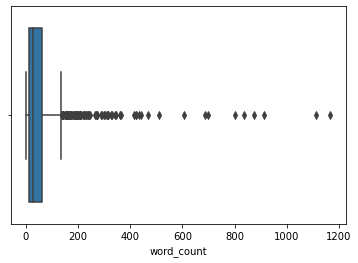

In [23]:
df_temp_1 = df[df['sub_class'] == 1]
temp_df = df_temp_1[['word_count','count_char']]
sns.boxplot(x=temp_df["word_count"])

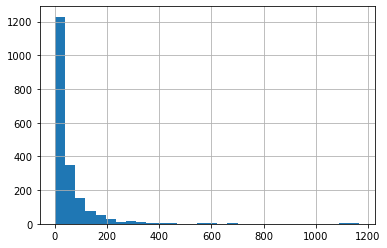

In [24]:
# Examine dist of both 'word_count' and 'count_char'
df['word_count'].hist(bins=30);

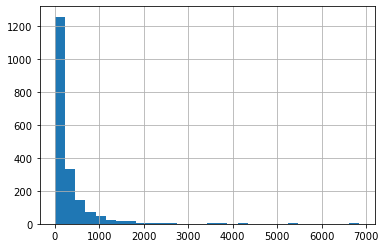

In [25]:
df['count_char'].hist(bins=30);

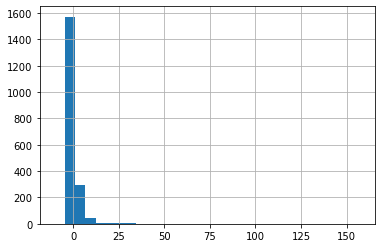

In [26]:
df['score'].hist(bins=30);

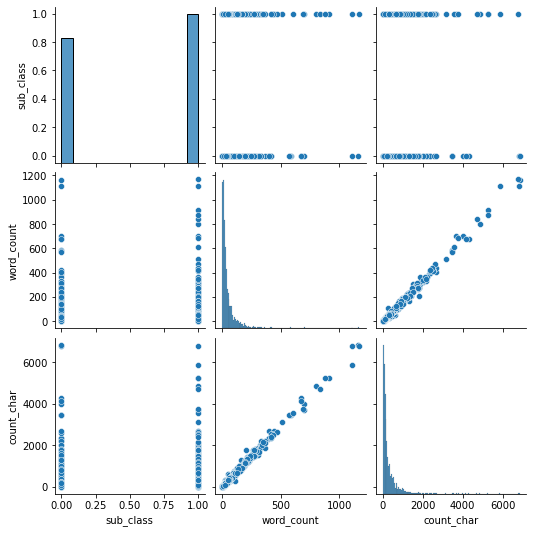

In [27]:
# Pairplot of subreddit, word_count, count_char
sns.pairplot(df[['sub_class', 'word_count', 'count_char']]);

- `word_count`, `count_char` and `score` appear to be higly skewed to the right, so performing a log tranform can give us a better 

In [28]:
# Sqrt transfromations:
# Because the data we want to tranform contains 0, sqrt can give us a 
# [Source]: https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45

df.loc[:,'word_count_sqrt'] = np.sqrt(df['word_count'].copy())
df.loc[:,'count_char_sqrt'] = np.sqrt(df['count_char'].copy())

In [29]:
df.describe()

,sub_class,score,word_count,count_char,word_count_sqrt,count_char_sqrt
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,0.543779,2.034818,54.991807,322.658986,6.092416,14.705426
std,0.498207,5.715221,97.362603,573.136963,4.228880,10.318136
min,0.000000,-10.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,1.000000,11.000000,64.000000,3.316625,8.000000
50%,1.000000,1.000000,26.000000,145.000000,5.099020,12.041595
75%,1.000000,1.000000,60.000000,352.000000,7.745967,18.761663
max,1.000000,157.000000,1167.000000,6844.000000,34.161382,82.728472


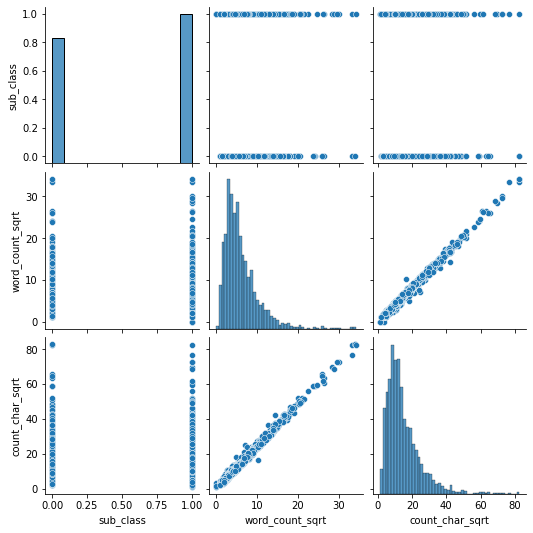

In [30]:
sns.pairplot(df[['sub_class', 'word_count_sqrt', 'count_char_sqrt']]);

## EDA on Vectorized text

In [31]:
url_regex = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"

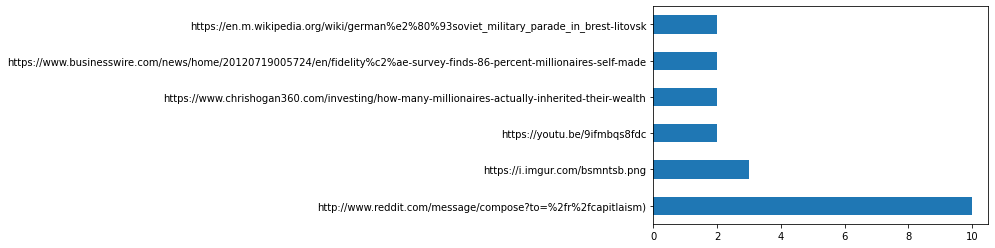

In [32]:
cvec_url = CountVectorizer(stop_words='english', token_pattern=url_regex, min_df=2)
cvec_url.fit(df['body'])
body_cv = cvec_url.transform(df['body'])
body_df = pd.DataFrame(body_cv.todense(), columns=cvec_url.get_feature_names())
top_25 = body_df.sum().sort_values(ascending=False).head(25)
body_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [33]:
top_25

http://www.reddit.com/message/compose?to=%2fr%2fcapitlaism)                                                               10
https://i.imgur.com/bsmntsb.png                                                                                            3
https://youtu.be/9ifmbqs8fdc                                                                                               2
https://www.chrishogan360.com/investing/how-many-millionaires-actually-inherited-their-wealth                              2
https://www.businesswire.com/news/home/20120719005724/en/fidelity%c2%ae-survey-finds-86-percent-millionaires-self-made     2
https://en.m.wikipedia.org/wiki/german%e2%80%93soviet_military_parade_in_brest-litovsk                                     2
dtype: int64

In [34]:
top_25df= top_25.to_frame()
top_25df.reset_index(drop=False, inplace=True)
top_25df = top_25df.rename(columns={'index':'URL', 0:'counts'})
top_25df = top_25df.sort_values(by=['counts'])

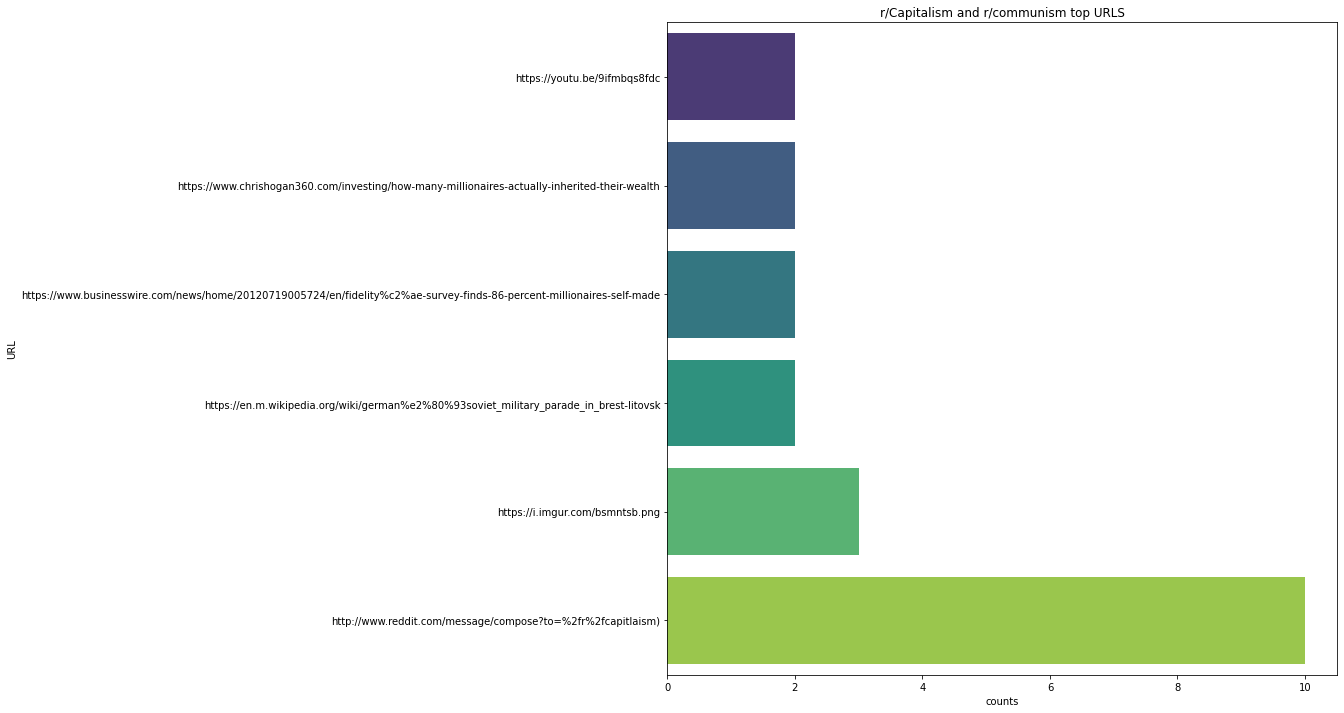

In [35]:
plt.figure(figsize=(12,12))
plt.title('r/Capitalism and r/communism top URLS')
ax = sns.barplot(x='counts', y="URL", palette = 'viridis', data=top_25df)
plt.savefig('../images/urls.png',bbox_inches = 'tight');

In [36]:
# Remove URLs from body, after seeing that URLs don't seem to have common high counts
regex_nums = "[0-9]+"
def my_ref_filter(string):
    result = re.sub(url_regex, '', string)
    result = re.sub(regex_nums, '', result)
    
    return result

In [37]:
df.loc[:, 'body'] = df['body'].apply(my_ref_filter).copy()

In [38]:
test_filter = '000aasf'
my_ref_filter(test_filter)

'aasf'

In [39]:
final_stopwords_list = stopwords.words('english') + stopwords.words('russian') 

In [40]:
cvec = CountVectorizer(stop_words= final_stopwords_list, min_df=2)

cvec.fit(df['body'])
body_cv = cvec.transform(df['body'])
body_df = pd.DataFrame(body_cv.todense(), columns=cvec.get_feature_names())
top_25 = body_df.sum().sort_values(ascending=False).head(25)

top_25df= top_25.to_frame()
top_25df.reset_index(drop=False, inplace=True)
top_25df = top_25df.rename(columns={'index':'words', 0:'counts'})
top_25df = top_25df.sort_values(by=['counts'])

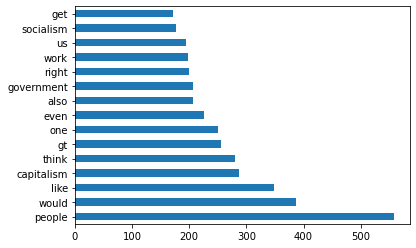

In [41]:
body_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

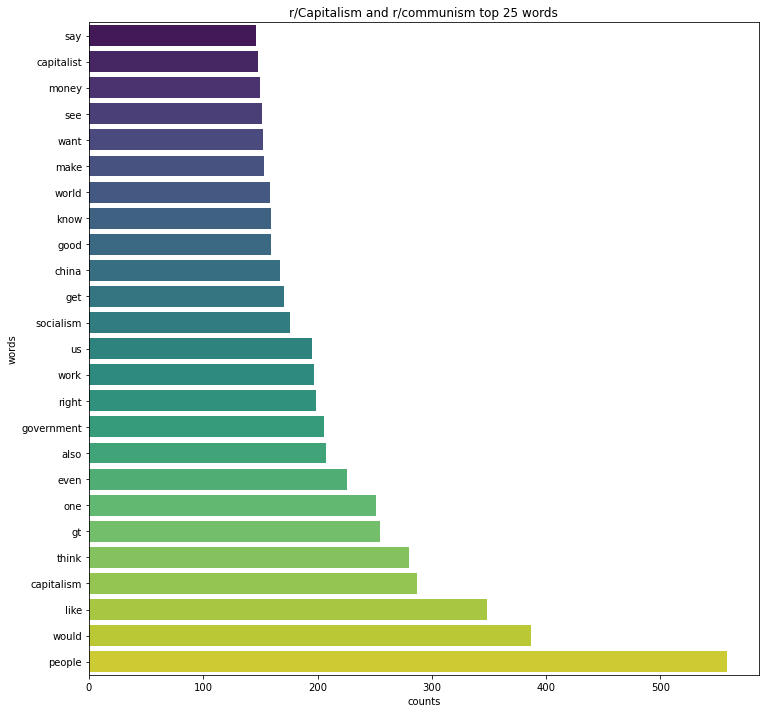

In [42]:
plt.figure(figsize=(12,12))
plt.title('r/Capitalism and r/communism top 25 words')
sns.barplot(x='counts', y="words", palette = 'viridis', data=top_25df)
plt.savefig('../images/top_25_both.png',bbox_inches = 'tight');

In [43]:
cvec = CountVectorizer(stop_words= final_stopwords_list, min_df=1)

df_temp_1 = df[df['sub_class'] == 1]

In [44]:
cvec.fit(df_temp_1['body'])
body_cv = cvec.transform(df_temp_1['body'])
body_df = pd.DataFrame(body_cv.todense(), columns=cvec.get_feature_names())
top_25 = body_df.sum().sort_values(ascending=False).head(25)

top_25df= top_25.to_frame()
top_25df.reset_index(drop=False, inplace=True)
top_25df = top_25df.rename(columns={'index':'words', 0:'counts'})
top_25df = top_25df.sort_values(by=['counts'])

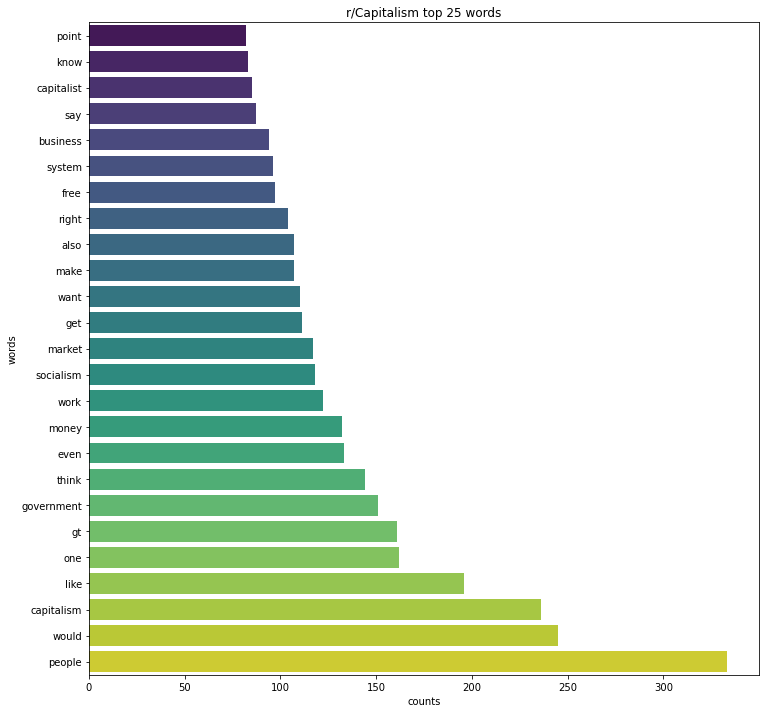

In [45]:
plt.figure(figsize=(12,12))
plt.title('r/Capitalism top 25 words')
sns.barplot(x='counts', y="words", palette = 'viridis', data=top_25df)
plt.savefig('../images/top_25_cap.png',bbox_inches = 'tight');

In [46]:
cvec = CountVectorizer(stop_words= final_stopwords_list, min_df=1)
df_temp_0 = df[df['sub_class'] == 0]

In [47]:
cvec.fit(df_temp_0['body'])
body_cv = cvec.transform(df_temp_0['body'])
body_df = pd.DataFrame(body_cv.todense(), columns=cvec.get_feature_names())
top_25 = body_df.sum().sort_values(ascending=False).head(25)

top_25df= top_25.to_frame()
top_25df.reset_index(drop=False, inplace=True)
top_25df = top_25df.rename(columns={'index':'words', 0:'counts'})
top_25df = top_25df.sort_values(by=['counts'])

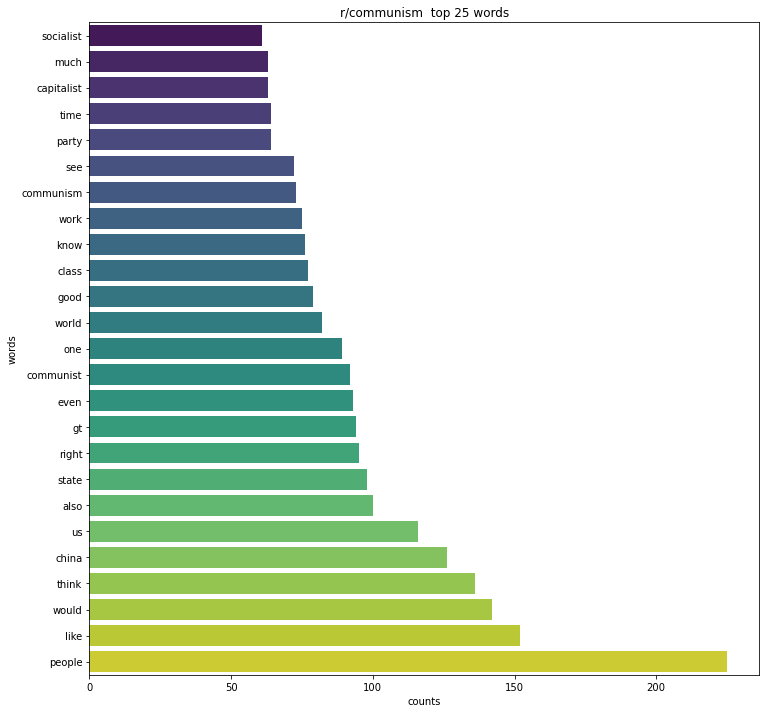

In [48]:
plt.figure(figsize=(12,12))
plt.title('r/communism  top 25 words')
sns.barplot(x='counts', y="words", palette = 'viridis', data=top_25df)
plt.savefig('../images/top_25_com.png',bbox_inches = 'tight');

In [49]:
#!python -m pip install wordcloud

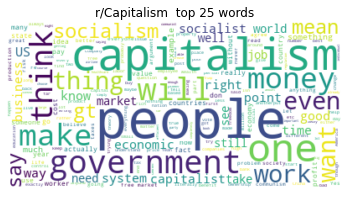

<Figure size 432x288 with 0 Axes>

In [50]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


text = " ".join(review for review in df_temp_1.body)

stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('r/Capitalism  top 25 words')
plt.show()
plt.savefig('../images/word_cloud_cap.png');

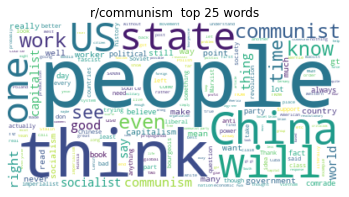

<Figure size 432x288 with 0 Axes>

In [51]:
text = " ".join(review for review in df_temp_0.body)

stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('r/communism  top 25 words')
plt.axis("off")
plt.show()
plt.savefig('../images/word_cloud_com.png');

In [52]:
body_df.head()

,_become_,_long,_çok,abandon,abdoul,abhorrent,ability,ablaze,able,ableist,...,советских,социалистических,союз,сталин,товарищ,北韓離脫住民定着支援事務所,翻墙,북한이탈주민정착지원사무소,하나院,하나원
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
body_df.shape

(891, 6410)

In [54]:
df.head()

,body,sub_class,score,id,word_count,count_char,word_count_sqrt,count_char_sqrt
3,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je,25,141,5.000000,11.874342
5,"No offense to the OP, but no one really knows ...",0,2,g98w052,142,816,11.916375,28.565714
6,None taken. I wasn’t expecting a silver bullet...,0,1,g98wloj,53,295,7.280110,17.175564
7,"Oh ok, thanks, now its just left to learn to m...",0,-1,g98x32f,39,187,6.244998,13.674794
9,what lol all I said is you should probably mak...,0,2,g98xoru,84,449,9.165151,21.189620


In [55]:
df.columns

Index(['body', 'sub_class', 'score', 'id', 'word_count', 'count_char',
       'word_count_sqrt', 'count_char_sqrt'],
      dtype='object')

In [56]:
df.shape

(1953, 8)

In [57]:
# IMPORTNAT ! **RESETIING INDEX**
test = df.reset_index(drop=True)

In [58]:
vect_plus_org = pd.concat([test, body_df], axis=1)
vect_plus_org.head()

,body,sub_class,score,id,word_count,count_char,word_count_sqrt,count_char_sqrt,_become_,_long,...,советских,социалистических,союз,сталин,товарищ,北韓離脫住民定着支援事務所,翻墙,북한이탈주민정착지원사무소,하나院,하나원
0,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je,25,141,5.000000,11.874342,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"No offense to the OP, but no one really knows ...",0,2,g98w052,142,816,11.916375,28.565714,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,None taken. I wasn’t expecting a silver bullet...,0,1,g98wloj,53,295,7.280110,17.175564,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Oh ok, thanks, now its just left to learn to m...",0,-1,g98x32f,39,187,6.244998,13.674794,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,what lol all I said is you should probably mak...,0,2,g98xoru,84,449,9.165151,21.189620,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA on VADER

In [59]:
corpus = list(df['body'])
id_corpus = list(df['id'])
sia = SentimentIntensityAnalyzer()

In [60]:
# create dataframe that contains text and the polarity scores for each tweet
# Reference taken from EC_local_flex exercie
dicts = []    
counter = 0
for text in corpus:
    scores = sia.polarity_scores(text)
    scores['body'] = text
    scores['id'] = id_corpus[counter]
    dicts.append(scores)
    counter+=1
df_vader = pd.DataFrame(dicts)
df_vader.head()

,neg,neu,pos,compound,body,id
0,0.078,0.799,0.124,0.2967,"Actually, I hadn't heard about that, and it is...",g98v0je
1,0.161,0.732,0.107,-0.8405,"No offense to the OP, but no one really knows ...",g98w052
2,0.046,0.907,0.046,0.0000,None taken. I wasn’t expecting a silver bullet...,g98wloj
3,0.194,0.686,0.121,-0.4767,"Oh ok, thanks, now its just left to learn to m...",g98x32f
4,0.070,0.790,0.140,0.7259,what lol all I said is you should probably mak...,g98xoru


In [61]:
df_vader.columns

Index(['neg', 'neu', 'pos', 'compound', 'body', 'id'], dtype='object')

In [62]:
print(f'Shape df: {df.shape}')
print(f'Shape body_df: {body_df.shape}')
print(f'Shape df_vader: {df_vader.shape}')

Shape df: (1953, 8)
Shape body_df: (891, 6410)
Shape df_vader: (1953, 6)


In [63]:
len(set(df['id']))

1953

In [64]:
len(set(df_vader['id']))

1953

In [65]:
var = (set(df_vader['id']) == set(df['id']))
print(var)

True


In [66]:
merged = pd.concat([vect_plus_org,df_vader], axis=1)
# remove duplicated columns
# URL: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns

merged = merged.loc[:,~merged.columns.duplicated()]
merged.head(1)

,body,sub_class,score,id,word_count,count_char,word_count_sqrt,count_char_sqrt,_become_,_long,...,товарищ,北韓離脫住民定着支援事務所,翻墙,북한이탈주민정착지원사무소,하나院,하나원,neg,neu,pos,compound
0,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je,25,141,5.0,11.874342,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.078,0.799,0.124,0.2967


In [67]:
pos_cap = merged[['sub_class', 'pos']]
neg_cap = merged[['sub_class', 'neg']]
neu_cap =  merged[['sub_class', 'neu']]
mask = pos_cap.loc[(pos_cap['sub_class'] == 1) & (pos_cap['pos']>0)]
mask_2 = neg_cap.loc[(neg_cap['sub_class'] == 1) & (neg_cap['neg']>0)]
mask_3 = neu_cap.loc[(neu_cap['sub_class'] == 1) & (neu_cap['neu']>0) & (neu_cap['neu']<1)]

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


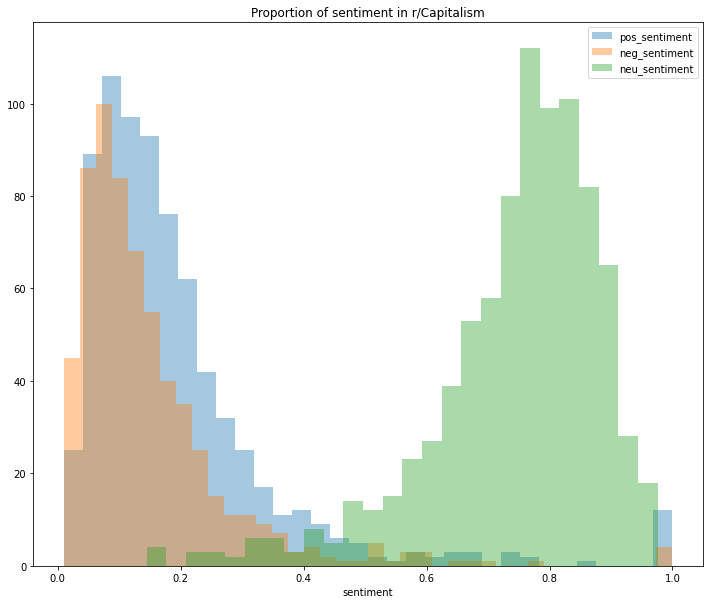

In [68]:
plt.figure(figsize=(12,10))
sns.distplot(mask['pos'],label='pos_sentiment',kde=False)
sns.distplot(mask_2['neg'],label='neg_sentiment',kde=False)
sns.distplot(mask_3['neu'],label='neu_sentiment',kde=False)
plt.xlabel('sentiment')
plt.legend()
plt.title('Proportion of sentiment in r/Capitalism')
plt.savefig('../images/prop_sent_cap.png',bbox_inches = 'tight');

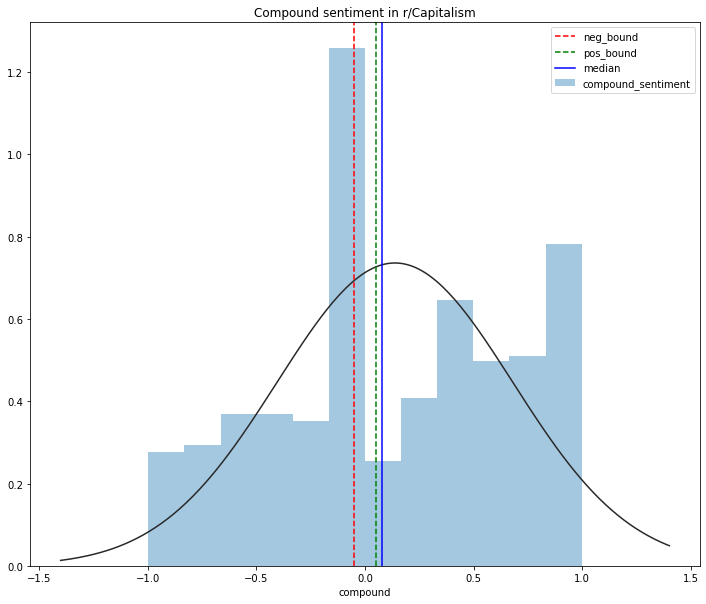

In [69]:
comp_cap =  merged[['sub_class', 'compound']]
mask = comp_cap.loc[(comp_cap['sub_class'] == 1)]
median=mask['compound'].median()
plt.figure(figsize=(12,10))
sns.distplot(mask['compound'],label='compound_sentiment',fit=norm, kde=False)
plt.axvline(x=-0.05, color='r',label='neg_bound', linestyle='--')
plt.axvline(x=0.05, color='g', label='pos_bound',linestyle='--')
plt.axvline(median, color='b', label='median',linestyle='-')

plt.legend()
plt.title('Compound sentiment in r/Capitalism')
plt.savefig('../images/dist_cap.png',bbox_inches = 'tight');

In [70]:
pos_co = merged[['sub_class', 'pos']]
neg_co = merged[['sub_class', 'neg']]
neu_co =  merged[['sub_class', 'neu']]

mask = pos_cap.loc[(pos_co['sub_class'] == 0) & (pos_co['pos']>0)]
mask_2 = neg_co.loc[(neg_co['sub_class'] == 0) & (neg_co['neg']>0)]
mask_3 = neu_co.loc[(neu_co['sub_class'] == 0) & (neu_co['neu']>0) & (neu_co['neu']<1)]

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


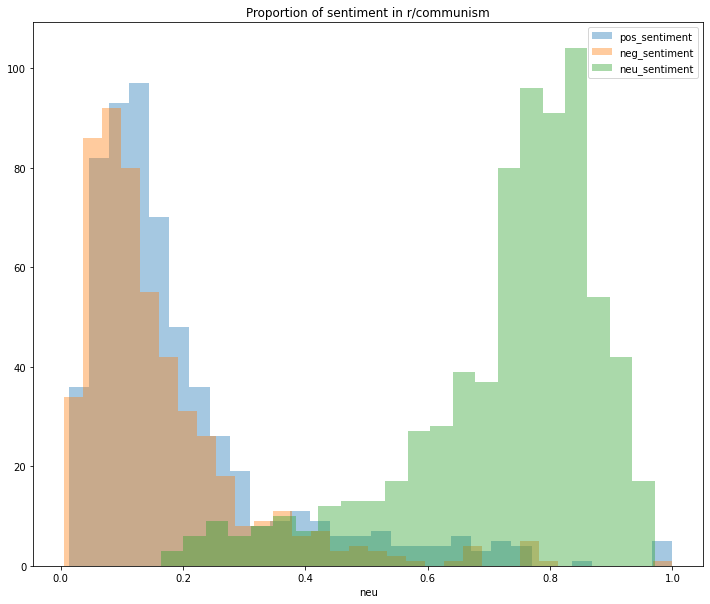

In [71]:
plt.figure(figsize=(12,10))
sns.distplot(mask['pos'],label='pos_sentiment' ,kde=False)
sns.distplot(mask_2['neg'],label='neg_sentiment', kde=False)
sns.distplot(mask_3['neu'],label='neu_sentiment',kde=False)

plt.legend()
plt.title('Proportion of sentiment in r/communism')
plt.savefig('../images/prop_sent_com.png',bbox_inches = 'tight');

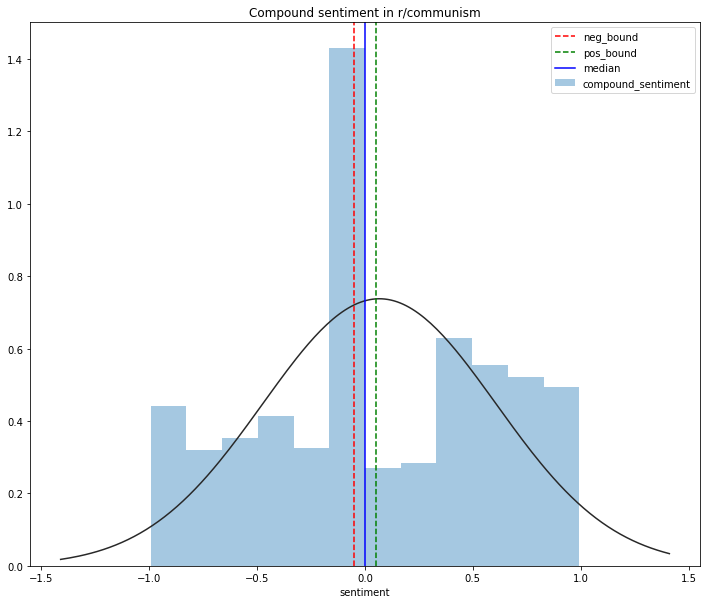

In [72]:
comp_co =  merged[['sub_class', 'compound']]
mask = comp_co.loc[(comp_co['sub_class'] == 0)]
median=mask['compound'].median()
plt.figure(figsize=(12,10))
sns.distplot(mask['compound'],label='compound_sentiment',fit=norm, kde=False)
plt.axvline(x=-0.05, color='r',label='neg_bound', linestyle='--')
plt.axvline(x=0.05, color='g', label='pos_bound',linestyle='--')
plt.axvline(median, color='b', label='median',linestyle='-')
plt.xlabel('sentiment')

plt.legend()
plt.title('Compound sentiment in r/communism')
plt.savefig('../images/dist_com.png',bbox_inches = 'tight');

### Export dataset used for modeling


In [73]:
#merged.to_csv('../data/data_modelingV2.csv', index=False)